In [62]:
#!pip install psycopg2


In [63]:
import psycopg2
import pandas as pd
import csv

### verify the conexion
try:
    # Connect to the database
    conn = psycopg2.connect(
        host="pg.ujueta.com",
        port="5432",
        user="consultoria",
        password="LmKTXJBXya!14]f9!2k]",
        database="postgres",
    )
except psycopg2.Error as e:
    print("Error connecting to the database:")
    print(e)
else:
    print("Connection established successfully")

Connection established successfully


In [64]:

### ventas diario apiladas
def export_forecast_to_csv():
    try:
        # connect to the database
        conn = psycopg2.connect(
            host="pg.ujueta.com",
            port="5432",
            user="consultoria",
            password="LmKTXJBXya!14]f9!2k]",
            database="postgres",
        )

        # create cursor
        with conn.cursor() as cur:

            # ececute a sql query

            cur.execute("SELECT * FROM forecast.ventas_diario")

            # fetch the results
            results = cur.fetchall()

            # open a file in the downloads folder

            with open(
                r"C:\Users\Alberto Florez\OneDrive\Documentos\GitHub\output_nov.csv",
                #"/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/outputs.csv",
                "w",
                newline="",
            ) as f:
                # create a csv writer
                writer = csv.writer(f)

                # write the column names
                writer.writerow([col[0] for col in cur.description])

                # write the query results
                writer.writerows(results)
    except Exception as e:
        print(f"An error ocurred: {e}")
    finally:
        # close the cursor and connection
        if conn:
            conn.close()


# Call the function to export data to csv
export_forecast_to_csv()


In [65]:
### manipulate data

import pandas as pd

# carga de datas
data = pd.read_csv(
    r"C:\Users\Alberto Florez\OneDrive\Documentos\GitHub\output_nov.csv"
    #"/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/outputs.csv"
)
# convertir en dataframe
df = pd.DataFrame(data)
df.head()

,docdate,codigo_articulo,cantidad
0,2022-01-03,AUACALR4,1
1,2022-01-03,AUACCH1,5
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3


In [66]:
df.shape

(88935, 3)

In [67]:
df['docdate'] = pd.to_datetime(df['docdate'], errors ='coerce')

(df.groupby([pd.Grouper(key='docdate', freq='MS'), 'codigo_articulo'])['cantidad']
 .sum()
 .reset_index()    
)

,docdate,codigo_articulo,cantidad
0,2022-01-01,AUAC265,1
1,2022-01-01,AUAC3-4-1,70
2,2022-01-01,AUACAC24NE,2
3,2022-01-01,AUACAE15,1
4,2022-01-01,AUACAE20,138
...,...,...,...
9811,2024-11-01,SOSWSWW2760,2
9812,2024-11-01,SOSWSWW3552,2
9813,2024-11-01,SOSWSWW4070MV,1
9814,2024-11-01,SOSWT1-111,14


In [68]:
# List of SKUs to filter
selected_skus = [
    'AUACAE30', 'AUACPB400', 'AUACRIM4F', 'AUACSH1000', 'HEELAG1141',
    'HEELAG1142KIT', 'HEELPW1770', 'HEELXID20', 'HEFUFCD12KIT',
    'HEFUFCD21', 'HEFUFD52', 'HEFUFG71', 'SOELCSVM501', 'SOELCSVM530',
    'SOELSI6140DV', 'SOFUFW181', 'SOFUFW185', 'SOFUFW33', 'SOFUFW35',
    'SOSWP2-517'
]

# Filter the dataset
filtered_df = df[df['codigo_articulo'].isin(selected_skus)]

In [69]:
print(filtered_df)

         docdate codigo_articulo  cantidad
2     2022-01-03       AUACPB400         1
3     2022-01-03       AUACRIM4F         5
4     2022-01-03      AUACSH1000         3
10    2022-01-03      HEELAG1141        56
22    2022-01-03      HEELPW1770         4
...          ...             ...       ...
88886 2024-11-29        HEFUFD52        22
88894 2024-11-29    SOELSI6140DV         4
88908 2024-11-29        SOFUFW33         8
88909 2024-11-29        SOFUFW35        24
88927 2024-11-29      SOSWP2-517        63

[13275 rows x 3 columns]


In [70]:
data_highdda = filtered_df[filtered_df['docdate'] >= '2022-01-01']
data_highdda

,docdate,codigo_articulo,cantidad
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3
10,2022-01-03,HEELAG1141,56
22,2022-01-03,HEELPW1770,4
...,...,...,...
88886,2024-11-29,HEFUFD52,22
88894,2024-11-29,SOELSI6140DV,4
88908,2024-11-29,SOFUFW33,8
88909,2024-11-29,SOFUFW35,24


In [71]:
#========================================================================================================================================
# Ajuste de Datos para statsforecast
#========================================================================================================================================

#-- Dato de ejemplo para función

def data_sf(df, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo'):
    df_m = df[[date, y, unique_id]]
    df_m.rename(columns={date : 'ds', y :'y', unique_id: 'unique_id'}, inplace=True)
  
    return df_m

df_m = data_sf(data_highdda, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo')
df_m
df_m.info()




<class 'pandas.core.frame.DataFrame'>
Index: 13275 entries, 2 to 88927
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         13275 non-null  datetime64[ns]
 1   y          13275 non-null  int64         
 2   unique_id  13275 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 414.8+ KB


In [72]:
#========================================================================================================================================
# Colección de modelos
#========================================================================================================================================
from statsforecast import StatsForecast #- Para instanciar los  modelos
from statsforecast.models import Naive

from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    HoltWinters,
    ADIDA,
    CrostonClassic as Croston, 
    IMAPA,
    TSB,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    Naive,
    SeasonalNaive,
    Theta,
    WindowAverage,
    Holt,
    CrostonOptimized,
)

#-- Parametros

# Número de días en el futuro a pronosticar
horizon = 12
# Ventana estacional: es 12 porque tenemos datos son mensuales
season_length = 12
# El número de dias que el modelo usará para hacer el forecast 
window_size = 12

# Lista de modelos a evaluar
models = [
    AutoARIMA(season_length=season_length),
    #AutoETS(season_length=season_length),
    HoltWinters(season_length=season_length),
    # ADIDA(),
    # Croston(),
    # IMAPA(),
    # TSB(alpha_d = 0.2, alpha_p = 0.2),
    # HistoricAverage(),
    # DOT(season_length=season_length),
    # Naive(),
    SeasonalNaive(season_length=season_length),
    # Theta(),
    # WindowAverage(window_size=3),  # Adjust `window_size` as needed
    Holt() #,
    # CrostonOptimized()
]

In [73]:
# StatsForecast.plot(df_m)

# Instanciando StatsForecast como sf
sf = StatsForecast( 
    models=models,
    freq='MS', #MS
    n_jobs=-1,
)


In [74]:
# Cross Validation
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mse, smape

crossvaldation_df = sf.cross_validation(
    df=df_m,
    h=horizon,
    step_size=horizon,
    n_windows=3
)



C:\Users\Alberto Florez\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [75]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y'], errors='ignore').columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(drop=False), smape)
evaluation_df.head(22)

,AutoARIMA,HoltWinters,SeasonalNaive,Holt,best_model
unique_id,,,,,
AUACAE30,0.657192,0.455800,0.443007,0.464888,SeasonalNaive
AUACPB400,0.398400,0.373022,0.458202,0.378009,HoltWinters
AUACRIM4F,0.395039,0.372244,0.497241,0.388079,HoltWinters
AUACSH1000,0.490115,0.588750,0.571090,0.593765,AutoARIMA
HEELAG1141,0.417608,0.577042,0.536683,0.570724,AutoARIMA
HEELAG1142KIT,0.694365,0.810976,0.547665,0.806180,SeasonalNaive
HEELPW1770,0.538028,0.665769,0.390286,0.689984,SeasonalNaive
HEELXID20,0.459879,0.459601,0.441991,0.463417,SeasonalNaive
HEFUFCD12KIT,0.473094,0.484746,0.600975,0.483096,AutoARIMA


In [76]:
#--- Selección del mejor modelo
fcst_df = sf.forecast(df=df_m, 
                      h=horizon, 
                      ## level=[90]
                     )
fcst_df.head()

C:\Users\Alberto Florez\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,HoltWinters,SeasonalNaive,Holt
unique_id,,,,,
AUACAE30,2024-12-01,4.653235,14.462228,1.0,8.441471
AUACAE30,2025-01-01,4.009992,7.856391,5.0,8.441830
AUACAE30,2025-02-01,2.451516,5.246260,1.0,8.442117
AUACAE30,2025-03-01,7.232359,8.225356,24.0,8.442346
AUACAE30,2025-04-01,7.363009,10.987700,27.0,8.442530


In [77]:
#-- Revisión para eliminar pornosticos constantes
fcst_df.reset_index(drop=False).groupby(['unique_id']).std()

,ds,AutoARIMA,HoltWinters,SeasonalNaive,Holt
unique_id,,,,,
AUACAE30,109 days 14:50:57.950696680,1.891034,2.796055,9.848474,0.000529
AUACPB400,109 days 14:50:57.950696680,0.960922,0.873301,5.053502,0.003184
AUACRIM4F,109 days 14:50:57.950696680,13.476712,7.308675,45.681705,0.296875
AUACSH1000,109 days 14:50:57.950696680,3.528405,3.234806,23.832115,0.002152
HEELAG1141,109 days 14:50:57.950696680,1.110554,2.470477,2.539088,0.019717
HEELAG1142KIT,109 days 14:50:57.950696680,9.587920,6.101375,36.619667,2.330803
HEELPW1770,109 days 14:50:57.950696680,0.114012,2.221827,0.651339,0.005906
HEELXID20,109 days 14:50:57.950696680,0.000000,1.127069,1.764550,0.011290
HEFUFCD12KIT,109 days 14:50:57.950696680,3.679935,6.758543,7.178989,0.169788


C:\Users\Alberto Florez\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


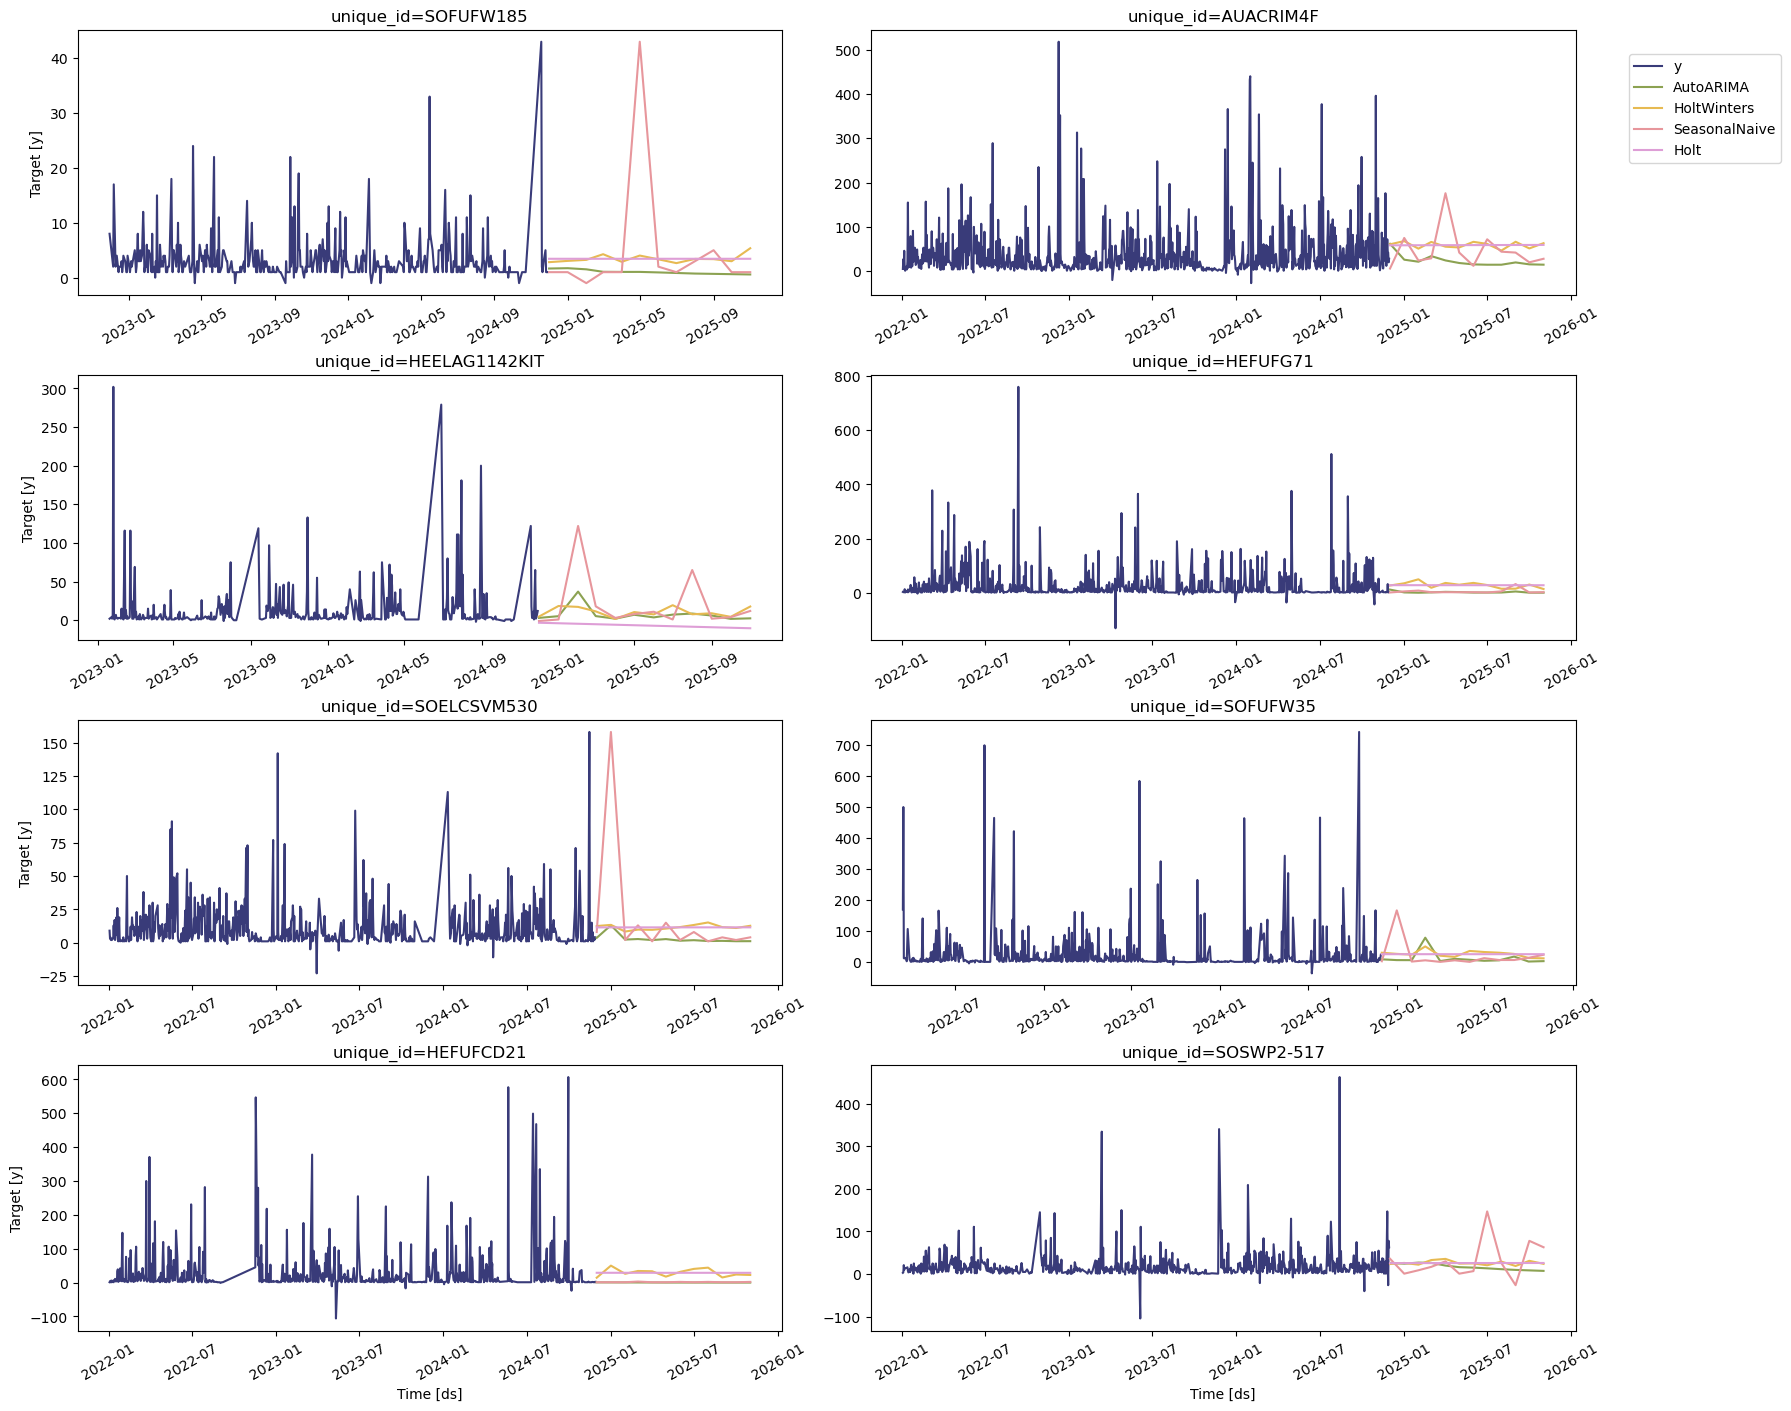

In [78]:
sf.plot(df_m,fcst_df)

In [79]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    col_bm = evaluation_df['best_model'].values[0]
    df = forecasts_df[col_bm] # Wide to long 
    df = df.reset_index(drop=False)
    df.columns = ['unique_id', 'best_model']
    return df

prod_forecasts_df = get_best_model_forecast(forecasts_df = fcst_df, 
                                            evaluation_df = evaluation_df)
prod_forecasts_df

,unique_id,best_model
0,AUACAE30,1.0
1,AUACAE30,5.0
2,AUACAE30,1.0
3,AUACAE30,24.0
4,AUACAE30,27.0
...,...,...
235,SOSWP2-517,147.0
236,SOSWP2-517,26.0
237,SOSWP2-517,-26.0
238,SOSWP2-517,78.0


In [80]:
prod_forecasts_df.to_excel("../output_01122024.xlsx", sheet_name='PronosticoMensual')